<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/blob/main/%5BPractice%5D_05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

**Model we will use:** This time we will use models within `tf.keras.applications` and apply them to our own problem. (recognizing food images)


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [7]:
!nvidia-smi

Thu May 27 14:56:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    23W /  75W |    199MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

🟢 [Important] 🔽
Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [8]:
!wget https://raw.githubusercontent.com/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/main/tensorflow-deep-learning/extras/helper_functions.py

--2021-05-27 14:56:44--  https://raw.githubusercontent.com/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/main/tensorflow-deep-learning/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-27 14:56:44 (85.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [9]:
# import helper function we will use in this script 🟢 [Important] 🔽
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## Get the data

In [10]:
# download and unzip our 10% 10 classes food data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-05-27 14:56:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  66.0MB/s    in 2.4s    

2021-05-27 14:56:48 (66.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [11]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [12]:
# Set up train and test paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


### To load data
🟢 [Important] 🔽   
This time we won't use `ImageDataGenerator`.  
We will use `image_dataset_from_directory()`  
Why?   
`image_dataset_from_directory()` loads data in `tf.data.Dataset` format which is much more handy and is faster.   

In [13]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [14]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                            image_size=IMAGE_SIZE, 
                                                                            label_mode = 'categorical', 
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, 
                                                                            image_size=IMAGE_SIZE, 
                                                                            label_mode = 'categorical', 
                                                                            batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [16]:
# Check class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [17]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.60867348e+01 6.50000000e+00 8.14285755e+00]
   [1.78418350e+01 2.22448897e+00 4.58163166e+00]
   [1.58316336e+01 5.27040815e+00 4.33673429e+00]
   ...
   [6.38468895e+01 3.28468895e+01 3.84688902e+00]
   [5.70714302e+01 2.60714283e+01 0.00000000e+00]
   [6.03725395e+01 2.83725414e+01 3.37254119e+00]]

  [[2.84693890e+01 9.01530647e+00 5.93367386e+00]
   [1.80306091e+01 1.74999785e+00 1.45918214e+00]
   [1.50918360e+01 3.48979568e+00 4.89285660e+00]
   ...
   [6.39999771e+01 3.29999771e+01 3.99997830e+00]
   [6.19949112e+01 3.09949093e+01 2.99491024e+00]
   [6.64745560e+01 3.44745560e+01 9.47455692e+00]]

  [[5.67500000e+01 3.52500000e+01 1.95306110e+01]
   [2.73622456e+01 8.50510311e+00 3.31632781e+00]
   [1.57193890e+01 1.86734784e+00 4.82142973e+00]
   ...
   [5.94744835e+01 2.84744854e+01 2.60199279e-01]
   [5.86428566e+01 2.76428566e+01 4.28571224e-01]
   [5.99336815e+01 2.63622513e+01 1.36225176e+00]]

  ...

  [[1.64433624e+02 1.69433624e+02 1.15005035e+02]
   [1

In [18]:
tf.reduce_max(images[0]), tf.reduce_min(images[0])

(<tf.Tensor: shape=(), dtype=float32, numpy=255.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

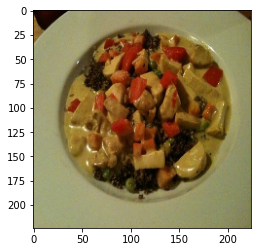

In [19]:
plt.imshow(images[0]/255.)

## Model 0: Creating a transfer learning feature extraction model using functional api


In [20]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the weights of base model so that weights are not updated during training
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')

# 4. If using ResnNet50V2 you will need to normalize inputs [Not required for efficientnet] (optional)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs to the base model: {x.shape}")

# 6. Average pool the outputs of the base_model (aggregate all the most important info, reduce number of parameters)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model
model_0_history = model_0.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              callbacks = [create_tensorboard_callback(
                                            dir_name = "/content/drive/MyDrive/Food_Classification/tensorboard",
                                            experiment_name = "05_model_0_10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs to the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_0_10_percent_feature_extraction/20210527-145653


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 44s 443ms/step - loss: 1.8986 - accuracy: 0.3507 - val_loss: 1.3325 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 9s 349ms/step - loss: 1.1551 - accuracy: 0.7200 - val_loss: 0.9317 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - 6s 254ms/step - loss: 0.8467 - accuracy: 0.8040 - val_loss: 0.7523 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - 6s 255ms/step - loss: 0.6942 - accuracy: 0.8453 - val_loss: 0.6512 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 9s 347ms/step - loss: 0.5962 - accuracy: 0.8520 - val_loss: 0.5909 - val_accuracy: 0.8240


In [21]:
# Evaluate of the full test data
model_0.evaluate(test_data)

79/79 [==============================] - 11s 140ms/step - loss: 0.6129 - accuracy: 0.8400


[0.6128968596458435, 0.8399999737739563]

In [22]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [23]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [24]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

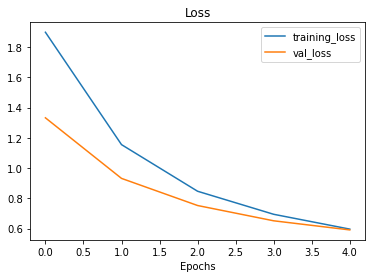

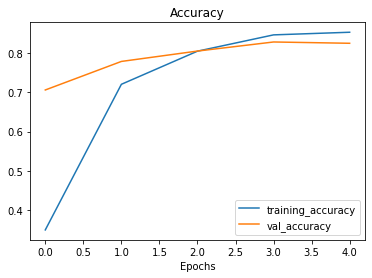

In [25]:
# Check out our model's training curves
plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.    

Let's try to visualize it with an example.  
Let's use a (1,4,4,3) tensor and pass it through GlobalAveragePooling2D.


In [26]:
# Define the input shape
temp_input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
temp_input_tensor = tf.random.normal(temp_input_shape)
print(f"Random input tensor:\n {temp_input_tensor}\n")

# Pass the random tensor through global average pooling layer
temp_global_average_pooled = tf.keras.layers.GlobalAveragePooling2D()(temp_input_tensor)
print(f"2D global average pooled tensor:\n {temp_global_average_pooled}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {temp_input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {temp_global_average_pooled.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [27]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(temp_input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

## Model 1: feature extraction transfer learning on 1% of the training data with data augmentation

### Getting and preprocessing data for model_1

In [28]:
# downloading the data for experiment 1 - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-05-27 14:58:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   189MB/s    in 0.7s    

2021-05-27 14:58:24 (189 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [29]:
# Specify train and test path
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [30]:
# Inspect data
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [31]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [32]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           batch_size = BATCH_SIZE,
                                                                           image_size = IMAGE_SIZE,
                                                                           label_mode = 'categorical')
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           batch_size = BATCH_SIZE,
                                                                           image_size = IMAGE_SIZE,
                                                                           label_mode = 'categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
* Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.
  
Using `tensorflow.keras.layers.experimental.preprocessing`.  

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [34]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation_layer = keras.Sequential([
                    preprocessing.RandomFlip('horizontal'),
                    preprocessing.RandomRotation(0.2),
                    preprocessing.RandomZoom(0.2),
                    preprocessing.RandomHeight(0.2),
                    preprocessing.RandomWidth(0.2),
                    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but Efficientnet has rescaling builtin
], name = "data_augmentation_layer")

### Visualize augmentations using our data_augmentation layer

In [35]:
# View a random image and compare it with augmented version [Add to helper_functions]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
def get_image_augmentations(data, dir_name):
  target_class = random.choice(data.class_names)
  target_dir = dir_name + "/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" + random_image

  # Read and plot original random image
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  plt.title(f"Original random image from class: {target_class}")
  plt.axis(False)

  # Read and plot augmented random image
  augmented_img = data_augmentation_layer(tf.expand_dims(img, axis = 0))
  plt.figure()
  plt.imshow(tf.squeeze(augmented_img)/255.)
  plt.title(f"Augmented random image from class: {target_class}")
  plt.axis(False);


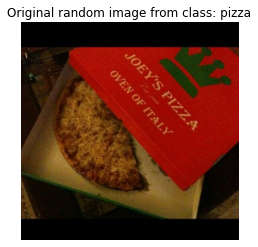

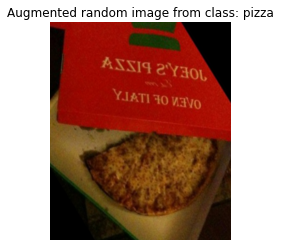

In [36]:
get_image_augmentations(train_data_1_percent, train_dir_1_percent)

### Create model 1 using functional API and add data augmentation layer to it

In [37]:
# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape = INPUT_SHAPE, name = 'input_layer')

# Add data augmentation layer
x = data_augmentation_layer(inputs)

# Give base_model inputs after augmenting them and don't train it
x = base_model(x, training = False)

# Pool the output features of the base_model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Add the output layer (dense layer)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_data_1_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_1_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              # Track training logs
                              callbacks = [create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                                       experiment_name = '05_model_1_1_percent_data_aug_feature_extraction')])


Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_1_1_percent_data_aug_feature_extraction/20210527-145829


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 13s 4s/step - loss: 2.4400 - accuracy: 0.0571 - val_loss: 2.2395 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1412 - accuracy: 0.2143 - val_loss: 2.1172 - val_accuracy: 0.2763
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0037 - accuracy: 0.3857 - val_loss: 2.0137 - val_accuracy: 0.3536
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8164 - accuracy: 0.5286 - val_loss: 1.9145 - val_accuracy: 0.4227
Epoch 5/5
3/3 [==============================] - 6s 3s/step - loss: 1.6280 - accuracy: 0.6286 - val_loss: 1.8355 - val_accuracy: 0.4375


In [38]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [38]:
# Evaluate on all test images
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

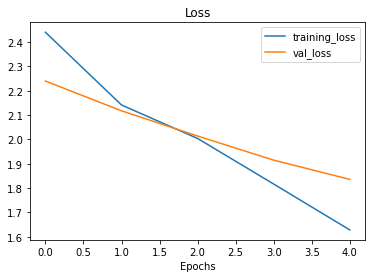

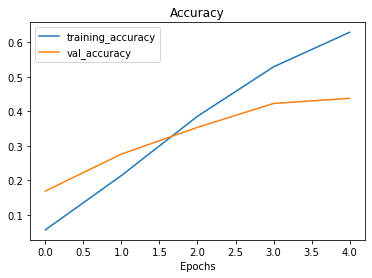

In [40]:
plot_loss_curves(model_1_history)

## Model 2: feature extraction transfer learning on 10% of the training data with data augmentation